# Задача на определении отрасли компании

Даны две табицы:
Таблица о переводах компании <b style="font-size: 14px">pays:</b>
- hash_inn_kt: Обезличенный ИНН отправителя
- hash_inn_dt: Обезличенный ИНН получателя
- week: Неделя
- count: Кол-во платежей в неделю
- sum: Сумма платежей в неделю; (обезличенная)

Информация о компании <b style="find-size: 14px">inn_info:</b>
- hash_inn: Обезличенный ИНН
- okved2: Обезличенная отрасль 
- region: Обезличенный регион 
- is_public: Флаг выборка для обучения \ контрольная

### План исследования:
1. Провести анализ данных. Изучить на выбросы, пропуски, типы данных, визуальный анализ данных, распределение признаков. Изучить платежи по каждой отрасли на обучающей выборке.
2. Подготовка данных для обучения и тестирования. Составление признаков, отбор признаков.
3. Обучение моделей, подбор параметров и поиск лучших.





 ## Анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas.plotting import scatter_matrix
import seaborn as sns

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_validate, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer, scale, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

### Dataset Pays

In [2]:
pays = pd.read_csv('pays.csv')
pays.head()

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6


In [3]:
pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   hash_inn_kt  int64  
 1   hash_inn_dt  int64  
 2   week         int64  
 3   count        int64  
 4   sum          float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [4]:
"number of duplicates".upper(), pays.duplicated().sum()

('NUMBER OF DUPLICATES', 0)

                sum   cnt
133          -0.400  2849
566          -0.396  1147
652          -0.392  1048
703          -0.388   991
776          -0.384   931
...             ...   ...
190513  2298399.600     1
189674  2348399.600     1
190396  2355999.600     1
213116  3296325.172     1
194949  3966399.600     1

[309644 rows x 2 columns]
--------------------------------------------------
count   5429025.00
mean        393.94
std        7259.42
min          -0.40
25%           3.28
50%          14.57
75%          69.20
max     3966399.60
Name: sum, dtype: float64
     count      cnt
26       0     1125
1        1  1420794
0        2  2360642
3        3   380622
2        4   631335
..     ...      ...
251   1546        1
252   1696        1
256   2246        1
301   2272        1
343   2530        1

[344 rows x 2 columns]
--------------------------------------------------
count   5430150.00
mean          2.92
std           5.05
min           0.00
25%           1.00
50%           2.00
75%

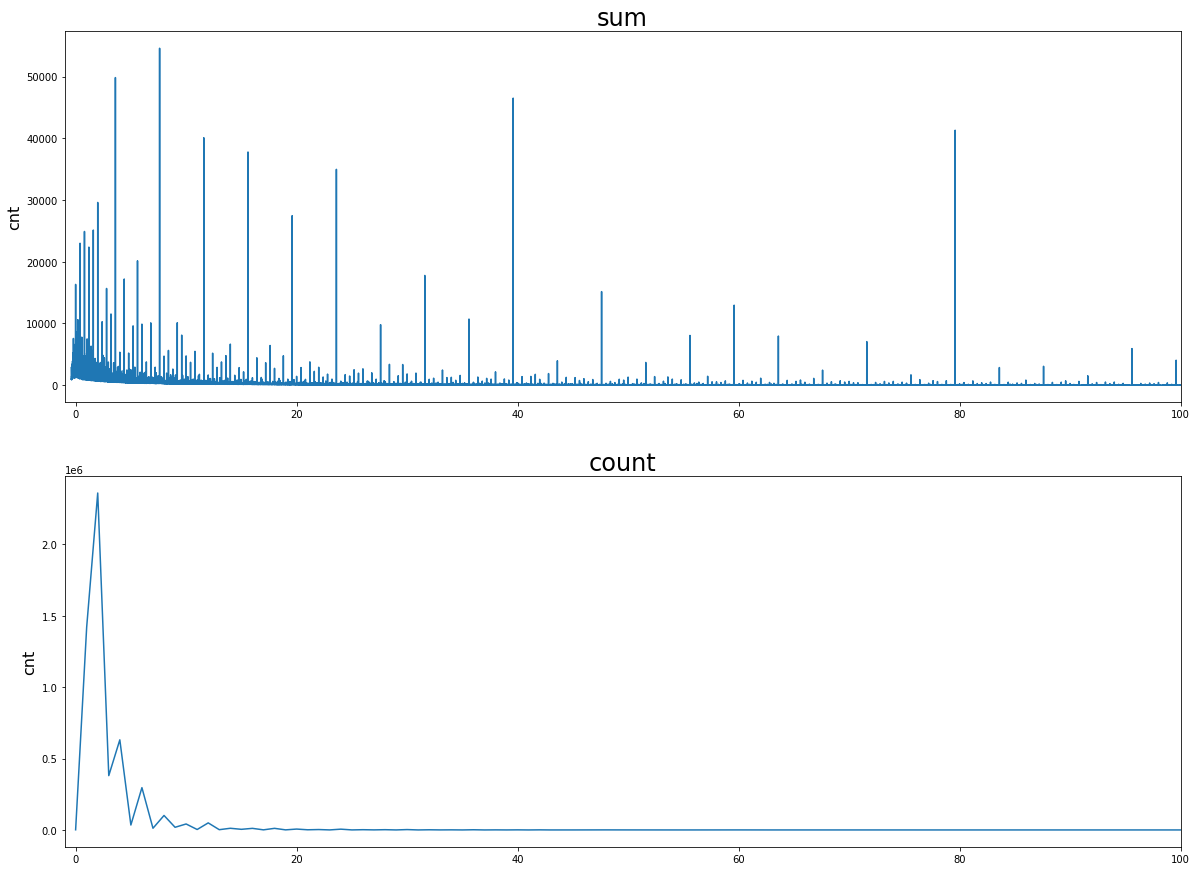

In [5]:
figure, axs = plt.subplots(2, 1, figsize=(20,15))

for index, column in enumerate(['sum', 'count']):
    current_column = pd.Series(pays[column])
    curr_column_val_count = current_column.value_counts().reset_index()
    curr_column_val_count.columns = [column, 'cnt']   
    curr_column_val_count = curr_column_val_count.sort_values(by=column)
    
    print(curr_column_val_count)

    axs[index].plot(curr_column_val_count[column], curr_column_val_count['cnt'])
    axs[index].set_title(column, size=24)
    axs[index].set_ylabel('cnt', size=16)
    axs[index].set_xlim([-1, 100])
    
    print('-' * 50)
    with pd.option_context('display.float_format', '{:.2f}'.format):
        print(current_column.describe())
    print('=' * 50)

In [6]:
for column in pays.columns:
    current_column = pays[column]
    print(column.upper())
    print(current_column.value_counts())
    print('--' * 50)
    print()

    number_of_nan = current_column.isna().sum()
    print("number of NaN".upper(), number_of_nan)

HASH_INN_KT
33988     55555
177448    50136
111553    22598
92978     21111
196449    20733
          ...  
50688         1
226937        1
231015        1
132695        1
34815         1
Name: hash_inn_kt, Length: 152160, dtype: int64
----------------------------------------------------------------------------------------------------

NUMBER OF NAN 0
HASH_INN_DT
123246    7034
221463    6569
91985     6515
194262    5648
33001     5184
          ... 
39454        1
152556       1
132070       1
121398       1
106050       1
Name: hash_inn_dt, Length: 189772, dtype: int64
----------------------------------------------------------------------------------------------------

NUMBER OF NAN 0
WEEK
8     275082
19    268772
10    265270
16    264595
13    263623
21    262867
14    261377
11    260708
12    260410
20    258990
15    256603
22    253398
4     246988
6     244260
5     243802
3     242213
2     241834
1     238772
17    227239
9     221704
18    193873
7     175444
0       2324

In [7]:
pays[pays['sum'].isna()]

,hash_inn_kt,hash_inn_dt,week,count,sum
2400,263,263,12,0,NaN
2401,263,263,13,0,NaN
2402,263,263,14,0,NaN
73323,3430,3430,19,0,NaN
74124,3493,3493,8,0,NaN
...,...,...,...,...,...
5402624,259374,259374,16,0,NaN
5402625,259374,259374,20,0,NaN
5408484,259705,259705,16,0,NaN
5424576,260125,260125,6,0,NaN


Text(0.5, 1.0, 'Scatter matrix for nubmer features')

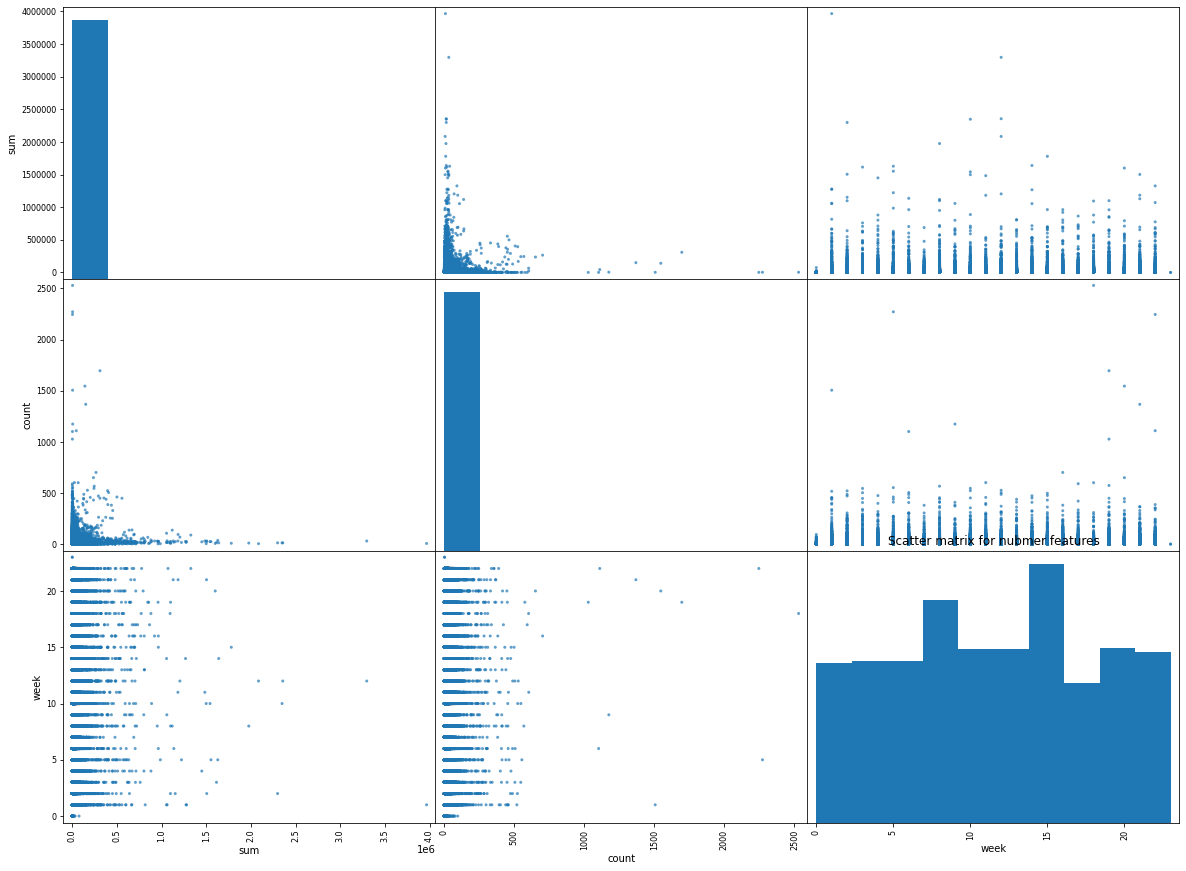

In [9]:
scatter_matrix(pays[['sum', 'count', 'week']], alpha=0.7, figsize=(20, 15), grid=True, diagonal='hist')
plt.title('Scatter matrix for nubmer features')

Привести в порядок столбец sum. Посмотреть на яшик с усуми и его метрики. Квантили размаха.
<br>

Смержить таблицы и провести анализ по отрасли(таргету) на обучающей выборке!!!
<br>

Добавить столбцы к ИНН компании. Сгрупировать данные по ИНН компании, 
- в среднем в неделю отправляли в каждый регион денег
- в среднем в неделю отправляли в каждый регион транзакций
- в среднем в неделю получали от каждого региона денег
- в среднем в неделю получали от каждого региона денег
<br>

<b>NOTES</b><br>
Перед обучением логистической регрессии, попробовать прологарифмировать сумму, сравнить результаты.<br>
Поиграть с границей.<br>
Кросс валидация.<br>
Грид сеарч.<br>
Посмотреть на корреляцию признаков.<br>



### Dataset Info About Company

In [10]:
inn = pd.read_csv('inn_info_public.csv')
inn.head()

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True


In [11]:
inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   hash_inn   240069 non-null  int64
 1   okved2     240069 non-null  int64
 2   region     240069 non-null  int64
 3   is_public  240069 non-null  bool 
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [12]:
"number of duplicates".upper(), inn.duplicated().sum()

('NUMBER OF DUPLICATES', 0)

In [13]:
curr_train = inn[inn['okved2'] != -1]['region'].value_counts()
columns_train = np.array(curr_train.index)
values_train = np.array(curr_train.values)

curr_test = inn[inn['okved2'] == -1]['region'].value_counts()
columns_test = np.array(curr_test.index)
values_test = np.array(curr_test.values)

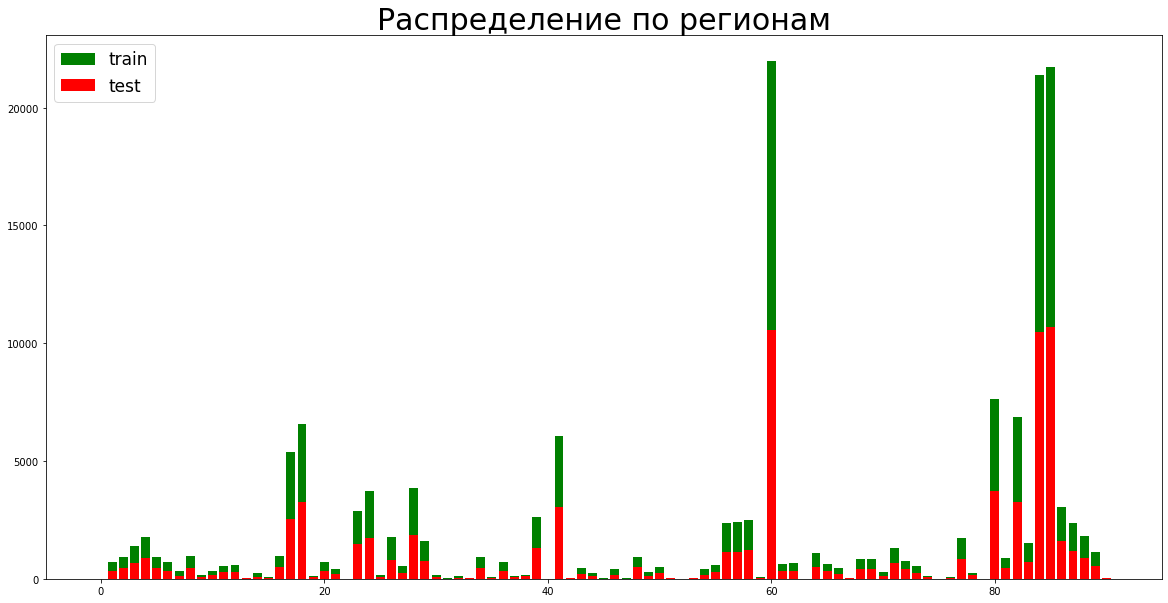

In [14]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по регионам', fontsize=30)
plt.bar(columns_train, values_train, color='g', width = barWidth)
plt.bar(columns_test, values_test, color='r', width = barWidth)
plt.legend(['train', 'test'], fontsize=17)

In [15]:
curr = inn[inn['okved2'] != -1]['okved2'].value_counts()
columns = np.array(curr.index)
values = np.array(curr.values)

<BarContainer object of 80 artists>

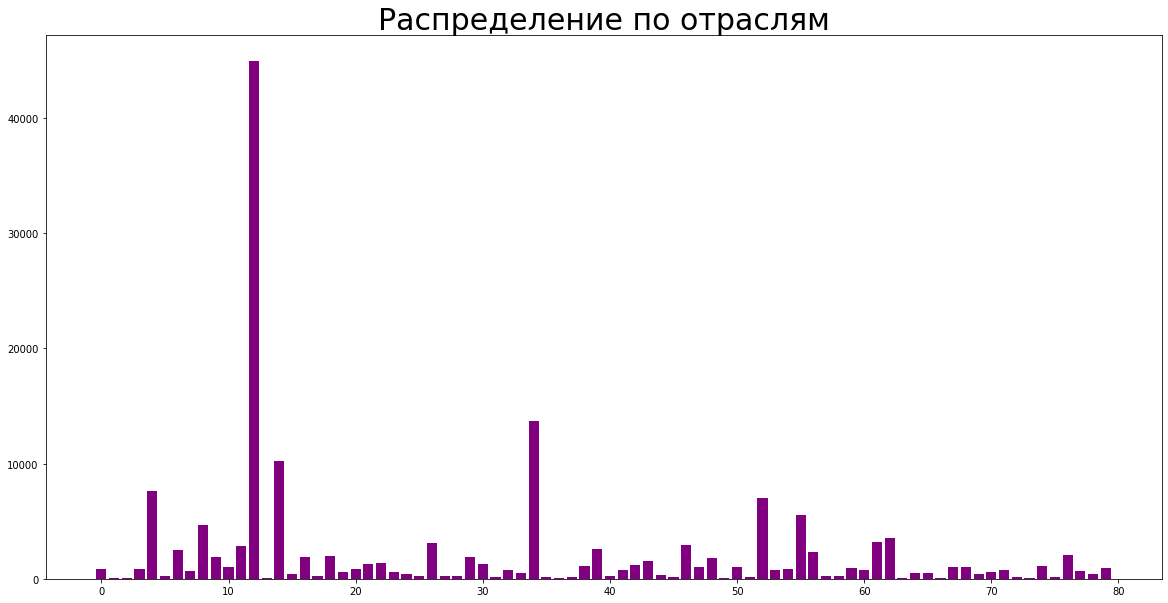

In [16]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по отраслям', fontsize=30)
plt.bar(columns, values, color='purple', width = barWidth)

### Merging dataframes

In [17]:
#delete rows where launder money
pays = pays[pays['hash_inn_kt'] != pays['hash_inn_dt']]

In [18]:
pays_merged = pays.copy()
pays_merged['hash_inn'] = pays_merged['hash_inn_kt']

pays_merged_dt = pays.copy()
pays_merged_dt['hash_inn'] = pays_merged_dt['hash_inn_dt']

In [19]:
pays_merged = pd.merge(pays_merged, inn, on='hash_inn', how='inner')
pays_merged

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region,is_public
0,0,7212,3,1,134.548,0,-1,84,False
1,0,7212,8,1,49.820,0,-1,84,False
2,0,7212,11,1,69.376,0,-1,84,False
3,0,7212,13,2,69.640,0,-1,84,False
4,0,7212,14,1,1205.560,0,-1,84,False
...,...,...,...,...,...,...,...,...,...
5316107,260511,77935,2,2,79.600,260511,12,84,True
5316108,260511,77935,5,2,399.600,260511,12,84,True
5316109,260511,77935,12,2,439.600,260511,12,84,True
5316110,260511,77935,14,2,7.600,260511,12,84,True


In [20]:
pays_merged_dt = pd.merge(pays_merged_dt, inn, on='hash_inn', how='inner')
pays_merged_dt

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region,is_public
0,0,7212,3,1,134.548,7212,36,84,True
1,0,7212,8,1,49.820,7212,36,84,True
2,0,7212,11,1,69.376,7212,36,84,True
3,0,7212,13,2,69.640,7212,36,84,True
4,0,7212,14,1,1205.560,7212,36,84,True
...,...,...,...,...,...,...,...,...,...
5316105,260458,79174,16,2,-0.280,79174,12,88,True
5316106,260458,96970,11,1,0.568,96970,12,17,True
5316107,260487,143637,11,3,15254.168,143637,-1,83,False
5316108,260503,30189,16,3,14.160,30189,22,60,True


### Исследовательский анализ (merged dataframes)

In [21]:
region_pivot = pays_merged.pivot_table(index=['region'], values=['sum', 'count'],
                                   aggfunc={'count': 'sum', 'sum': 'sum'})

region_pivot_dt = pays_merged_dt.pivot_table(index=['region'], values=['sum', 'count'],
                                   aggfunc={'count': 'sum', 'sum': 'sum'})

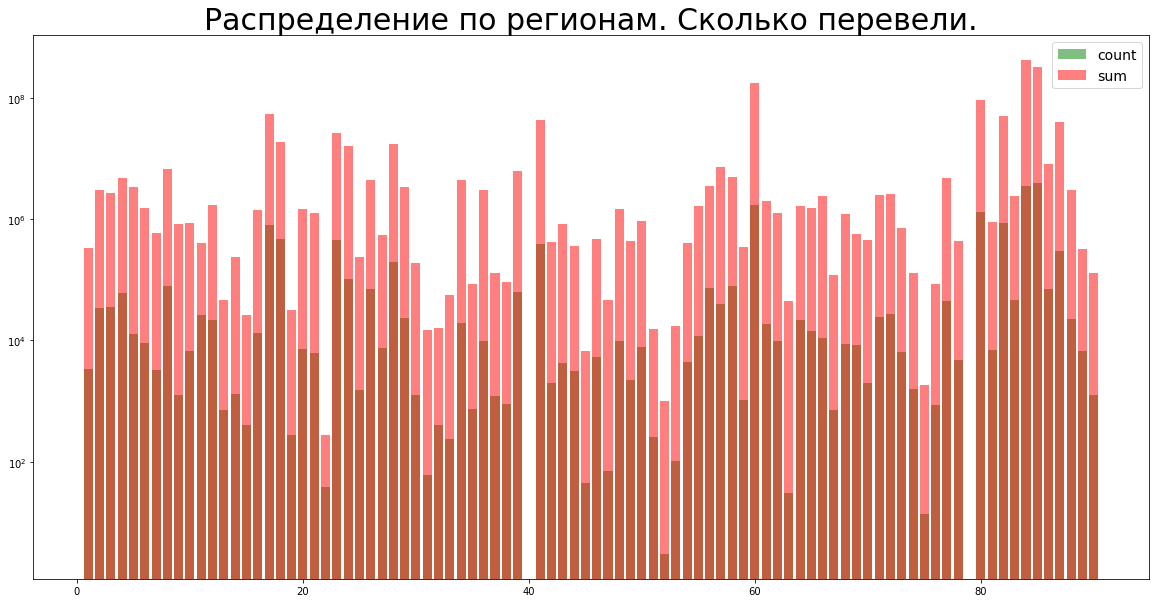

In [22]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по регионам. Сколько перевели.', fontsize=30)

columns = np.array(region_pivot.index)
values_count = np.array(region_pivot['count'])
values_sum = np.array(region_pivot['sum'])

plt.bar(columns, values_count, color='g', width = 0.8, log=True, alpha=0.5)
plt.bar(columns, values_sum, color='r', width = 0.8, log=True, alpha=0.5)
plt.legend(['count', 'sum'], fontsize=14)

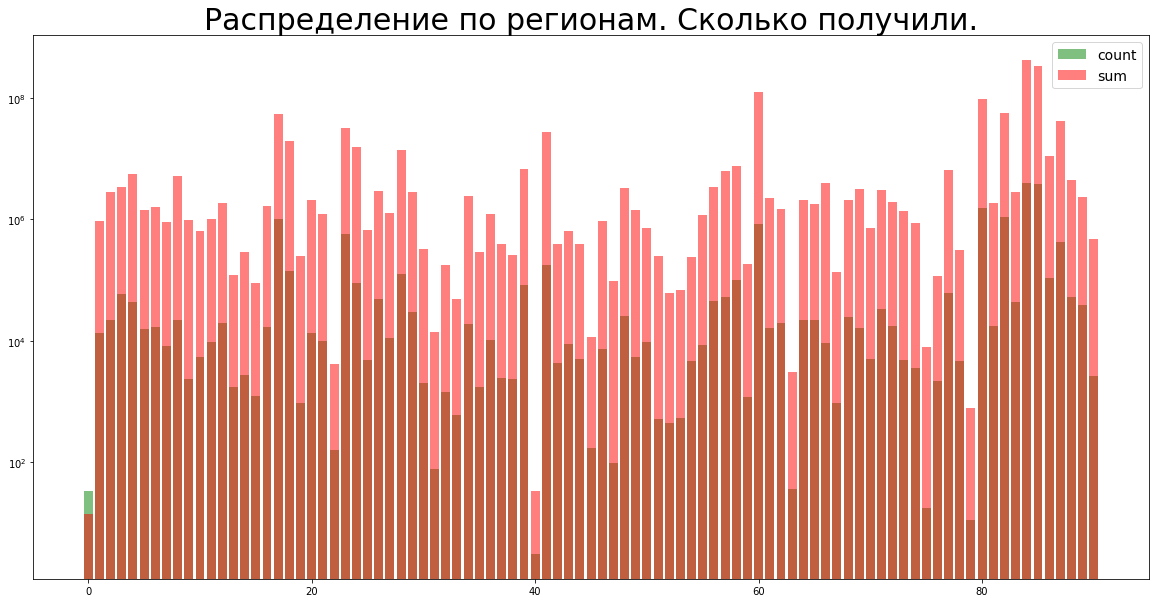

In [23]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по регионам. Сколько получили.', fontsize=30)

columns = np.array(region_pivot_dt.index)
values_count = np.array(region_pivot_dt['count'])
values_sum = np.array(region_pivot_dt['sum'])

plt.bar(columns, values_count, color='g', width = 0.8, log=True, alpha=0.5)
plt.bar(columns, values_sum, color='r', width = 0.8, log=True, alpha=0.5)
plt.legend(['count', 'sum'], fontsize=14)

In [24]:
okved_pivot = pays_merged.pivot_table(index=['okved2'], values=['sum', 'count'],
                                   aggfunc={'count': 'sum', 'sum': 'mean'})
okved_pivot = okved_pivot[1:]

okved_pivot_dt = pays_merged_dt.pivot_table(index=['okved2'], values=['sum', 'count'],
                                   aggfunc={'count': 'sum', 'sum': 'mean'})
okved_pivot_dt = okved_pivot_dt[1:]


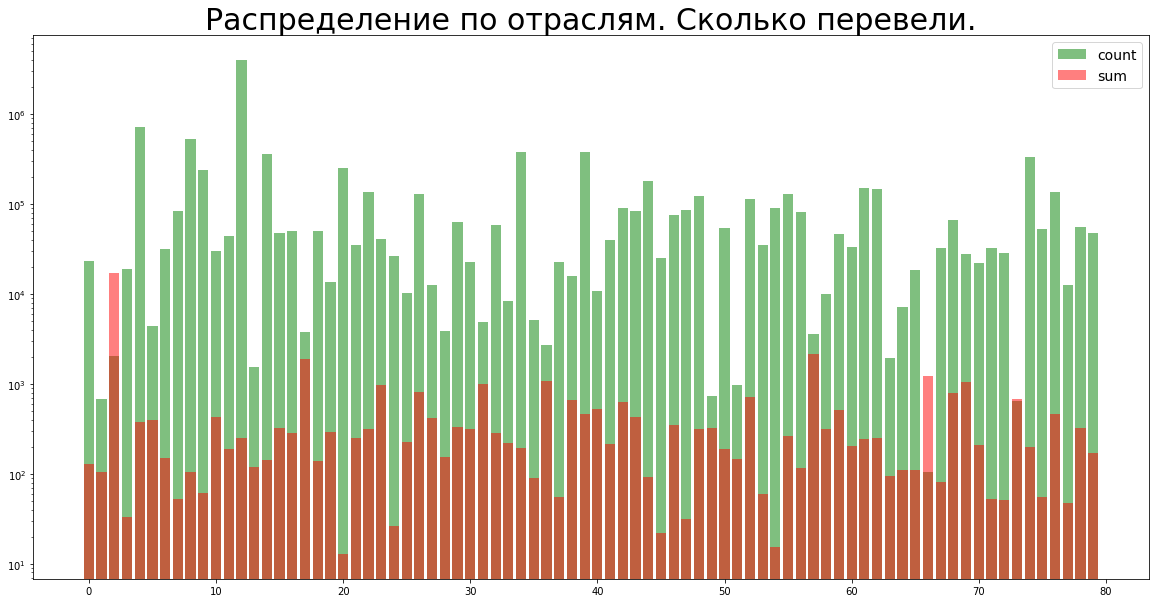

In [25]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по отраслям. Сколько перевели.', fontsize=30)

columns = np.array(okved_pivot.index)
values_count = np.array(okved_pivot['count'])
values_sum = np.array(okved_pivot['sum'])

plt.bar(columns, values_count, color='g', width = 0.8, log=True, alpha=0.5)
plt.bar(columns, values_sum, color='r', width = 0.8, log=True, alpha=0.5)
plt.legend(['count', 'sum'], fontsize=14)

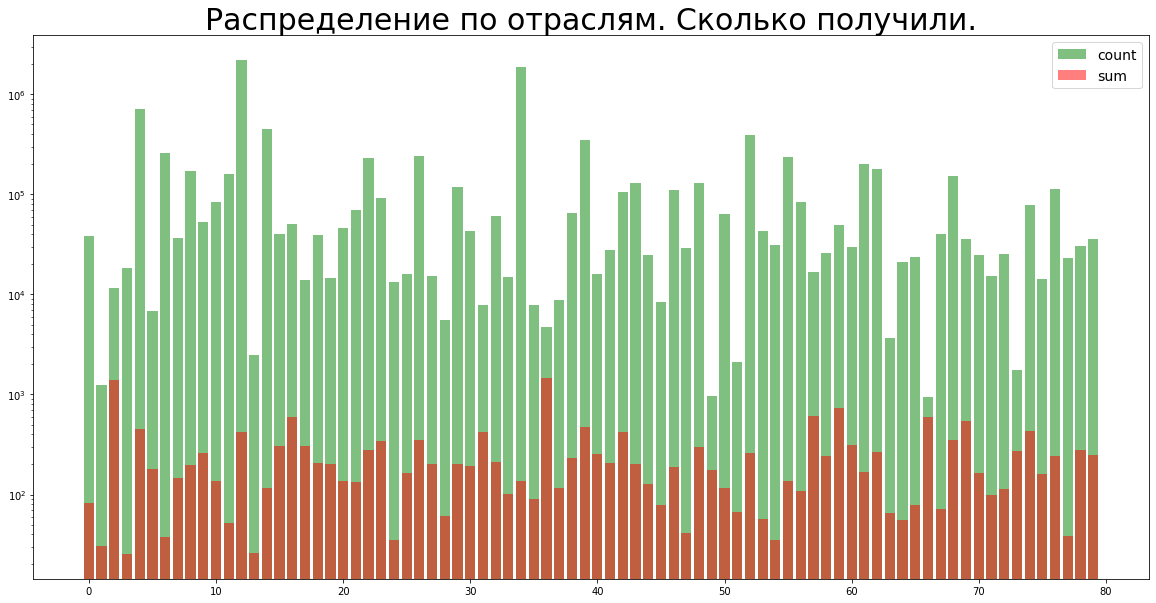

In [26]:
barWidth = 0.8
plt.figure(figsize=(20,10))
plt.title('Распределение по отраслям. Сколько получили.', fontsize=30)

columns = np.array(okved_pivot_dt.index)
values_count = np.array(okved_pivot_dt['count'])
values_sum = np.array(okved_pivot_dt['sum'])

plt.bar(columns, values_count, color='g', width = 0.8, log=True, alpha=0.5)
plt.bar(columns, values_sum, color='r', width = 0.8, log=True, alpha=0.5)
plt.legend(['count', 'sum'], fontsize=14)